## Esse dataset contém o numero de casos confirmasdos dos primeiros 12 meses de covid.O número de casos foi mantido para cada mês. Nós vamos fazer a previsão para os quatro meses finais do ano.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt;
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/mlptrab1/mortoscovid - sales-cars.csv


## Aqui lemos o dataset que nós subimos no kaggle após mudanças


In [2]:
df_mortos = pd.read_csv('/kaggle/input/mlptrab1/mortoscovid - sales-cars.csv')


Mostramos um pouco de como é o dataset.

In [3]:
df_mortos.head()

,Month,Mortos
0,2020-01,889
1,2020-02,46875
2,2020-03,397601
3,2020-04,4311214
4,2020-05,9609604


Aqui mudamos a coluna de mês para formato de data.

In [4]:
df_mortos.index = pd.to_datetime(df_mortos.Month, format='%Y-%m')

In [5]:
df_mortos = df_mortos.resample("M").sum()

In [6]:
df_mortos.head()

,Mortos
Month,
2020-01-31,889
2020-02-29,46875
2020-03-31,397601
2020-04-30,4311214
2020-05-31,9609604


### Aqui mostramos a curva das mortes durante o ano.

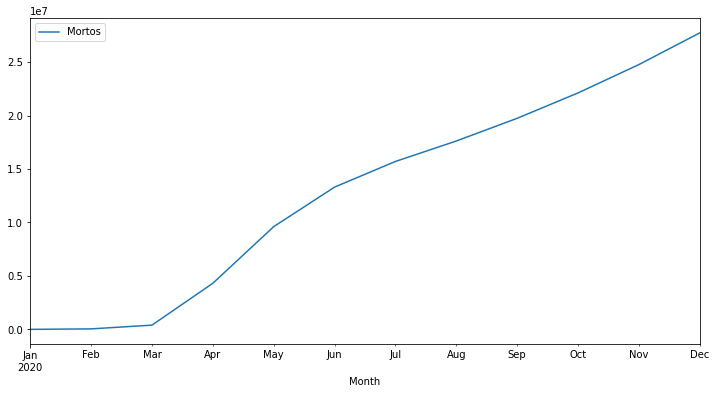

In [7]:
df_mortos.plot(figsize=(12,6));

**Nós queremos prever os próximos quatro meses. Entretanto, nós não poderíamos ver o quão bons são nossos resultados se não tivessemos nossos quatro meses de verdade para comparar. Com isso,deixamos os últimos quatro meses como teste. Eu deixo o resto como treino.**

In [8]:
# Train Test Split
train = df_mortos[:-4]
test = df_mortos[-4:]

In [9]:
train.head()

,Mortos
Month,
2020-01-31,889
2020-02-29,46875
2020-03-31,397601
2020-04-30,4311214
2020-05-31,9609604


In [10]:
test.head()

,Mortos
Month,
2020-09-30,19746779
2020-10-31,22121347
2020-11-30,24774315
2020-12-31,27738890


### Neste código, a função generate_lag é usada para gerar recursos atrasados (lagged features) para previsão de séries temporais. Ela recebe um array unidimensional de dados e gera pares de entrada e saída com um atraso específico (n) para previsão de séries temporais.

In [11]:
def generate_lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])
    
    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1,n)

In [12]:
X, y, last_batch_values = generate_lag(train.Mortos.values, 3)

In [13]:
X

array([[     889,    46875,   397601],
       [   46875,   397601,  4311214],
       [  397601,  4311214,  9609604],
       [ 4311214,  9609604, 13309053],
       [ 9609604, 13309053, 15709667]])

In [14]:
y

array([ 4311214,  9609604, 13309053, 15709667, 17621280])

In [15]:
last_batch_values

array([[13309053, 15709667, 17621280]])

# Construindo o modelo


In [16]:
def mlp_model(input_, y_, epochs=2000):   
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    print(model.fit(input_, y_, epochs=epochs))
    return model

In [17]:
model = mlp_model(X,y, epochs=3000)#escolhemos 3000 épocas nos baseando em resultados anteriores
model


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Epoch 1/3000
1/1 [==============================] - 1s 566ms/step - loss: 287062292955136.0000
Epoch 2/3000
1/1 [==============================] - 0s 4ms/step - loss: 280159189991424.0000
Epoch 3/3000
1/1 [==============================] - 0s 4ms/step - loss: 273448572026880.0000
Epoch 4/3000
1/1 [==============================] - 0s 4ms/step - loss: 266811522154496.0000
Epoch 5/3000
1/1 [==============================] - 0s 4ms/step - loss: 260257032962048.0000
Epoch 6/3000
1/1 [==============================] - 0s 4ms/step - loss: 253832130985984.0000
Epoch 7/3000
1/1 [==============================] - 0s 5ms/step - loss: 247470110015488.0000
Epoch 8/3000
1/1 [==============================] - 0s 4ms/step - loss: 241210295844864.0000
Epoch 9/3000
1/1 [==============================] - 0s 4ms/step - loss: 235088893706240.0000
Epoch 10/3000
1/1 [==============================] - 0s 3ms/step - loss: 229106541133824.0000
Epoch 11/3000
1/1 [==============================] - 0s 4ms/step - 

# Previsão


In [18]:
def forecast_function(model, last_batch, n):
    in_value = last_batch.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(last_batch.shape)
    return np.array(preds).ravel()

In [19]:
pred = forecast_function(model, last_batch_values, 4)

In [20]:
pred

array([19496408., 21661896., 24123442., 26852398.], dtype=float32)

In [21]:
test['Predicao_mortos']=pred

In [22]:
test.head()

,Mortos,Predicao_mortos
Month,,
2020-09-30,19746779,19496408.0
2020-10-31,22121347,21661896.0
2020-11-30,24774315,24123442.0
2020-12-31,27738890,26852398.0


# Mostrar a diferença entre Número de mortos e a Predição de mortos

<AxesSubplot:xlabel='Month'>

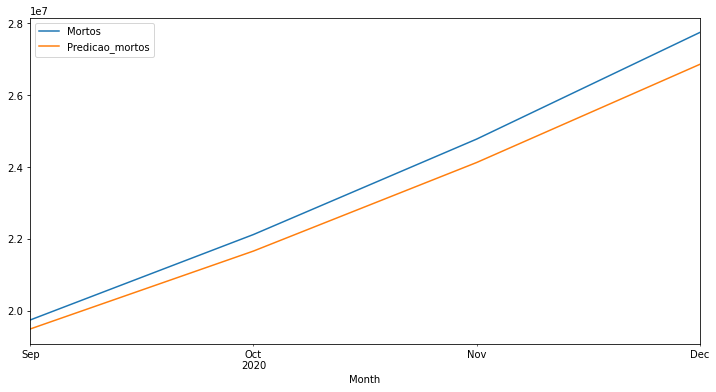

In [23]:
test.plot(figsize=(12,6))

#  Calcular o erro linha a linha entre as mortes e as mortes preditas como percentagem nos dados de teste

In [24]:
def error_function(df,column_1,column_2):
    data = df.copy()
    my_list = []
    for i in range(len(data)):
        x = (data[column_2][i]*100)/data[column_1][i]
        if x >= 100:
            error = x-100
            #data['error_percentage'][i] = error
            my_list.append(error)
        else:
            error = 100-x
            my_list.append(error)
            #data['error_percentage'][i] = error
    data['error_percentage'] = my_list
    return data

In [25]:
column_1 = 'Mortos'
column_2 = 'Predicao_mortos'
df_new = error_function(test,column_1,column_2)

In [26]:
df_new

,Mortos,Predicao_mortos,error_percentage
Month,,,
2020-09-30,19746779,19496408.0,1.267908
2020-10-31,22121347,21661896.0,2.076958
2020-11-30,24774315,24123442.0,2.627209
2020-12-31,27738890,26852398.0,3.195845


# Encontrando o erro médio


In [27]:
def mean_error(df,error_column):
    total = 0
    for i in range(len(df)):
        total += df[error_column][i]
    mean_error_ = total/(len(df))
    return mean_error_

In [28]:
error_rate = mean_error(df_new,'error_percentage')

In [29]:
error_rate

2.2919799445592126

**Se quisermos ver quantos óbitos ocorreram na realidade e quanto previmos, encontraremos o erro percentual.


In [30]:
soma_de_mortos = sum(df_new.Mortos.values)

In [31]:
soma_de_mortos

94381331

In [32]:
soma_de_mortespreditas = sum(df_new.Predicao_mortos.values)

In [33]:
soma_de_mortespreditas

92134144.0

In [34]:
rate_of_actual_and_predict_sums = (soma_de_mortespreditas*100)/soma_de_mortos

In [35]:
if rate_of_actual_and_predict_sums >= 100:
    total_percentage = rate_of_actual_and_predict_sums - 100
else:
    total_percentage = 100-rate_of_actual_and_predict_sums

# Aqui está nossa taxa de erro:

In [36]:
print('ERRO: ',total_percentage)

ERRO:  2.3809655746431417
